In [1]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Load the CSV files
df_curated = pd.read_csv('train_curated.csv')
df_noisy = pd.read_csv('train_noisy.csv')

# Paths to the audio files
audio_path_curated = '/Users/owo/HOUSE/@DUNE/@AI/Sound Classification2/freesound-audio-tagging-2019/train_curated'
audio_path_noisy = '/Users/owo/HOUSE/@DUNE/@AI/Sound Classification2/freesound-audio-tagging-2019/train_noisy'

# Concatenate the DataFrames
df = pd.concat([df_curated, df_noisy], ignore_index=True)

In [2]:
import librosa
import warnings
import os
def drop_unloadable_files(df, audio_dir):
    # Iterate over the DataFrame
    for i, row in df.iterrows():
        audio_file = os.path.join(audio_dir, row['fname'])
        try:
            # Try to load the audio file
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                librosa.load(audio_file, sr=None)
        except Exception:
            # If loading fails, drop the row
            df = df.drop(i)
    return df

# Drop rows with unloadable audio files from the curated and noisy DataFrames
df_curated = drop_unloadable_files(df_curated, audio_path_curated)
df_noisy = drop_unloadable_files(df_noisy, audio_path_noisy)

# Concatenate the curated and noisy DataFrames
df = pd.concat([df_curated, df_noisy], ignore_index=True)
df

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping
...,...,...
23149,fffc7128.wav,Accordion
23150,fffcf57b.wav,Acoustic_guitar
23151,fffd1871.wav,"Water_tap_and_faucet,Sink_(filling_or_washing)"
23152,fffe9808.wav,Clapping


In [3]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

from sklearn.preprocessing import MultiLabelBinarizer

# Split the labels on the commas to create a list of labels for each sample
df['labels'] = df['labels'].str.split(',')

# Create a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# One-hot encode the labels
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('labels')),
                          columns=mlb.classes_,
                          index=df.index))
df

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,0006ae4e.wav,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0019ef41.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,001ec0ad.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0026c7cb.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0026f116.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23149,fffc7128.wav,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23150,fffcf57b.wav,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23151,fffd1871.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
23152,fffe9808.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
import os

def load_and_fix_length(fname, duration=2, sr=22050):
    # Paths to the audio files
    audio_path_curated = '/Users/owo/HOUSE/@DUNE/@AI/Sound Classification2/freesound-audio-tagging-2019/train_curated'
    audio_path_noisy = '/Users/owo/HOUSE/@DUNE/@AI/Sound Classification2/freesound-audio-tagging-2019/train_noisy'
    
    # Check if the file exists in the curated directory
    if os.path.exists(os.path.join(audio_path_curated, fname)):
        filename = os.path.join(audio_path_curated, fname)
    # Otherwise, check the noisy directory
    elif os.path.exists(os.path.join(audio_path_noisy, fname)):
        filename = os.path.join(audio_path_noisy, fname)
    else:
        raise FileNotFoundError(f"{fname} not found in both directories.")
    
    # Load the audio file
    y, _ = librosa.load(filename, sr=sr)

    # If the audio is too short, pad it with zeros
    if len(y) < sr * duration:
        y = np.pad(y, (0, int(sr * duration) - len(y)))
    # If the audio is too long, truncate it
    elif len(y) > sr * duration:
        y = y[:int(sr * duration)]
    
    return y


In [5]:
def get_mel_spectrogram(y, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    # Compute the spectrogram
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    D_abs = np.abs(D)
    # Convert to Mel scale
    mel_spec = librosa.feature.melspectrogram(S=librosa.amplitude_to_db(D_abs), sr=sr, n_mels=n_mels)
    return mel_spec

In [7]:
# Replace with your own spectrogram computation
spectrograms = [get_mel_spectrogram(load_and_fix_length(filename)) for filename in df['fname']]
#labels_encoded = mlb.transform(df['labels'])
#spectrograms.shape

In [8]:
class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128*32*21, 1024)
        self.fc2 = nn.Linear(1024, len(mlb.classes_))

    def forward(self, x):
        x = x.unsqueeze(1)  # Add an extra dimension for the single channel
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [9]:
import os

def load_and_fix_length(fname, duration=2, sr=22050):
    # Paths to the audio files
    audio_path_curated = '/Users/owo/HOUSE/@DUNE/@AI/Sound Classification2/freesound-audio-tagging-2019/train_curated'
    audio_path_noisy = '/Users/owo/HOUSE/@DUNE/@AI/Sound Classification2/freesound-audio-tagging-2019/train_noisy'
    
    # Check if the file exists in the curated directory
    if os.path.exists(os.path.join(audio_path_curated, fname)):
        filename = os.path.join(audio_path_curated, fname)
    # Otherwise, check the noisy directory
    elif os.path.exists(os.path.join(audio_path_noisy, fname)):
        filename = os.path.join(audio_path_noisy, fname)
    else:
        raise FileNotFoundError(f"{fname} not found in both directories.")
    
    # Load the audio file
    y, _ = librosa.load(filename, sr=sr)

    # If the audio is too short, pad it with zeros
    if len(y) < sr * duration:
        y = np.pad(y, (0, int(sr * duration) - len(y)))
    # If the audio is too long, truncate it
    elif len(y) > sr * duration:
        y = y[:int(sr * duration)]
    
    return y

In [10]:
from sklearn.model_selection import train_test_split

# Create a labels DataFrame
labels = df.drop(columns='fname')

# Convert the spectrograms and labels to numpy arrays
X = np.array(spectrograms)
y = labels.to_numpy()

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from torch.utils.data import TensorDataset, DataLoader

# Convert the training and validation sets to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create PyTorch datasets from the tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create PyTorch dataloaders from the datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [16]:
import torch
import time
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.nn import DataParallel

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'mps'
# Create the model, loss function and optimizer
model = AudioClassifier().to(device)
if torch.cuda.device_count() > 1:  # Check if multiple GPUs are available
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)
    
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters())

# For storing losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 1
best_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for inputs, labels in train_loader:
        print(inputs.shape)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)

    # Save the model if it's the best so far
    if val_loss < best_loss:
        torch.save(model.state_dict(), 'AI2.pth')
        best_loss = val_loss

    end_time = time.time()
    elapsed_time = end_time - start_time
    estimated_time = elapsed_time * (num_epochs - epoch - 1)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}, Elapsed Time: {elapsed_time:.2f}s, Estimated Time Left: {estimated_time:.2f}s")

print("Finished Training")

torch.Size([32, 128, 87])
torch.Size([32, 128, 87])
torch.Size([32, 128, 87])
torch.Size([32, 128, 87])
torch.Size([32, 128, 87])
torch.Size([32, 128, 87])
torch.Size([32, 128, 87])
torch.Size([32, 128, 87])
torch.Size([32, 128, 87])
torch.Size([32, 128, 87])


KeyboardInterrupt: 

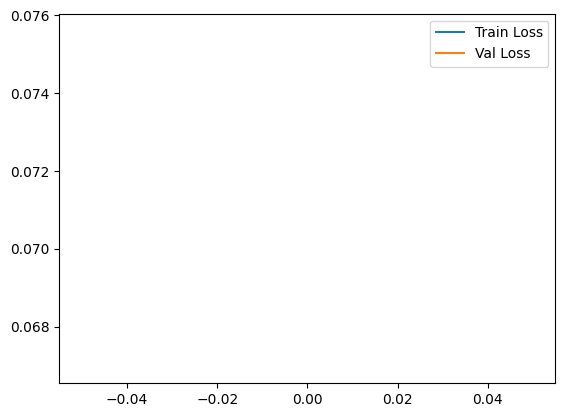

In [14]:
# Plot the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

In [29]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the CSV file
df = pd.read_csv('train_noisy.csv')

# Split the labels on the commas to create a list of labels for each sample
df['labels'] = df['labels'].str.split(',')

# Get unique labels
labels = pd.unique(df['labels'].explode())

# Create and fit the LabelEncoder
le = LabelEncoder()
le.fit(labels)
labels.shape

(80,)

In [31]:
import sounddevice as sd
import librosa
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder

def get_mel_spectrogram(y, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    # Compute the spectrogram
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    D_abs = np.abs(D)
    # Convert to Mel scale
    mel_spec = librosa.feature.melspectrogram(S=librosa.amplitude_to_db(D_abs), sr=sr, n_mels=n_mels)
    return mel_spec

#le = LabelEncoder()

# Load the trained model
model = AudioClassifier()
model.load_state_dict(torch.load('AI2.pth'))
model.eval()

# Record audio
duration = 2  # seconds
fs = 44100  # Sample rate
recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished
print(recording.shape)
# Preprocess audio
recording = np.squeeze(recording)  # Remove the singleton dimension
print(recording.shape)
recording = librosa.resample(recording, orig_sr=fs, target_sr=22050)  # Resample the recording
print(recording.shape)
mel_spec = get_mel_spectrogram(recording)  # Compute the Mel spectrogram
print(mel_spec.shape)
# Make prediction
mel_spec = torch.from_numpy(mel_spec).unsqueeze(0).float()  # Add two singleton dimensions at the beginning
print(mel_spec.shape)
outputs = model(mel_spec)
probs = torch.nn.functional.softmax(outputs, dim=1)
top_prob, top_label = torch.max(probs, dim=1)

print(f"Predicted label: {le.inverse_transform([top_label.item()])[0]}")
print(f"Probability: {top_prob.item() * 100:.2f}%")

(88200, 1)
(88200,)
(44100,)
(128, 87)
torch.Size([1, 128, 87])


NotFittedError: This LabelEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [34]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the CSV file
df = pd.read_csv('train_noisy.csv')

# Split the labels on the commas to create a list of labels for each sample
df['labels'] = df['labels'].str.split(',')

# Get unique labels
labels = pd.unique(df['labels'].explode())

# Create and fit the LabelEncoder
le = LabelEncoder()
le.fit(labels)

import sounddevice as sd
import librosa
import numpy as np
import torch

def get_mel_spectrogram(y, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    # Compute the spectrogram
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    D_abs = np.abs(D)
    # Convert to Mel scale
    mel_spec = librosa.feature.melspectrogram(S=librosa.amplitude_to_db(D_abs), sr=sr, n_mels=n_mels)
    return mel_spec

# Load the trained model
model = AudioClassifier()
model.load_state_dict(torch.load('AI2.pth'))
model.eval()

# Record audio
duration = 2  # seconds
fs = 44100  # Sample rate
recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished

# Preprocess audio
recording = np.squeeze(recording)  # Remove the singleton dimension
recording = librosa.resample(recording, orig_sr=fs, target_sr=22050)  # Resample the recording
mel_spec = get_mel_spectrogram(recording)  # Compute the Mel spectrogram

# Make prediction
mel_spec = torch.from_numpy(mel_spec).unsqueeze(0).float()  # Add two singleton dimensions at the beginning
outputs = model(mel_spec)
probs = torch.nn.functional.softmax(outputs, dim=1)
top_prob, top_label = torch.max(probs, dim=1)

print(f"Predicted label: {le.inverse_transform([top_label.item()])[0]}")
print(f"Probability: {top_prob.item() * 100:.2f}%")


Predicted label: Acoustic_guitar
Probability: 52.98%


# Diary
2023.07.24 0109i

I honestly spent like 15 hours to make this today. It took a lot of time but since I did 'urban 8 sound' before. It was slightly OK but still frustrating. I was almost done finishing this project then I noticed that some of the label has MORE than one label at a time. Then I have to do this whole thing over again . That was my first drag, and the second drag was at the fact I accidentally deleted the whole thing pressing undo in GitHub. Thankfully I had all the things in chat GPT, so that from there I was easily recovered.  
I still have a problem with real time analizer but I can sort it out later  
I have to go to work tommorrow, I have to go to sleep.  